# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores",
    "device": "cuda",
    "lr": 0.0001,
    "x_shape": [2, 200],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 16000, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag", "lowpass_+/-10MHz", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag", "take_200", "resample_20Msps_to_25Msps"],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 420,
    "dataset_seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_14', 'O_26', 'O_32', 'O_50', 'O_44', 'O_8', 'O_20', 'O_38'}


{'C_5', 'C_4', 'C_3', 'C_2', 'C_1'}


tensor([[[ 0.6771,  0.6049, -0.6388,  ...,  0.1252, -1.1136,  0.0521],
         [ 0.1621,  1.3147,  0.4124,  ...,  0.8546,  0.6386,  0.8458]],

        [[-0.6997,  0.2883,  0.8559,  ...,  0.5130,  1.2371,  0.6823],
         [-0.5248, -1.3202,  0.2191,  ..., -0.5431,  0.3696, -0.6693]],

        [[-0.0389,  1.1807,  0.4981,  ...,  0.8179,  0.4623,  0.8006],
         [-0.6127, -0.4203,  0.7069,  ...,  0.0047,  1.1766,  0.0143]],

        ...,

        [[ 0.7358,  0.4660, -0.7318,  ..., -0.0115, -1.2610, -0.1188],
         [ 0.1727,  1.1991,  0.2903,  ...,  0.8442,  0.6025,  1.0250]],

        [[ 0.9985,  0.7848, -1.0215,  ..., -0.1714, -0.3680,  1.0334],
         [ 0.1019,  0.8947,  0.2864,  ...,  0.9916,  0.8126,  0.6934]],

        [[ 0.8913,  0.9787, -0.7169,  ...,  0.5588,  0.5193,  1.2103],
         [-0.7172,  0.1559,  1.1444,  ...,  1.0353,  0.5671, -0.4114]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 200)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 46.7885, train_label_loss: 3.0260, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 1875.6295, train_label_loss: 1.2497, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 1877.6446, train_label_loss: 1.1374, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 1874.9066, train_label_loss: 1.1968, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 1872.3580, train_label_loss: 0.9034, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 1872.2608, train_label_loss: 1.0103, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2329.8244, train_label_loss: 1.0238, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2213.3852, train_label_loss: 0.7759, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 1874.5740, train_label_loss: 1.5270, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 1875.3139, train_label_loss: 0.6569, 


epoch: 1, source_val_acc_label: 0.6872, target_val_acc_label: 0.5207, source_val_label_loss: 9.3789, target_val_label_loss: 2836.9343, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.7431, train_label_loss: 1.3254, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 1876.9479, train_label_loss: 1.0862, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 1881.4637, train_label_loss: 0.8669, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 1877.7342, train_label_loss: 0.9204, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 1874.4489, train_label_loss: 0.8509, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 1879.0646, train_label_loss: 0.7381, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2319.4725, train_label_loss: 0.5970, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2227.4892, train_label_loss: 0.8624, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 1877.9623, train_label_loss: 1.1326, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 1858.4453, train_label_loss: 0.4752, 


epoch: 2, source_val_acc_label: 0.7354, target_val_acc_label: 0.5780, source_val_label_loss: 0.7190, target_val_label_loss: 223.7365, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7318, train_label_loss: 0.4704, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 1877.5798, train_label_loss: 0.7772, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 1880.3978, train_label_loss: 1.0618, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 1878.2530, train_label_loss: 0.6208, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 1873.6595, train_label_loss: 0.5768, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 1876.4669, train_label_loss: 0.7054, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2310.8974, train_label_loss: 0.4113, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2220.7038, train_label_loss: 0.6215, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 1877.1646, train_label_loss: 0.5176, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 1876.4502, train_label_loss: 0.4136, 


epoch: 3, source_val_acc_label: 0.7915, target_val_acc_label: 0.5865, source_val_label_loss: 0.5856, target_val_label_loss: 308.4452, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.7247, train_label_loss: 0.5130, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 1854.0483, train_label_loss: 0.6958, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 1767.4995, train_label_loss: 0.2770, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 1840.5384, train_label_loss: 0.4266, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 1854.6231, train_label_loss: 0.7588, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 1856.8104, train_label_loss: 0.8949, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2295.4224, train_label_loss: 0.3996, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2177.6797, train_label_loss: 0.5719, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 1825.6601, train_label_loss: 0.6182, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 1838.7871, train_label_loss: 0.4982, 


epoch: 4, source_val_acc_label: 0.7858, target_val_acc_label: 0.6083, source_val_label_loss: 0.5820, target_val_label_loss: 221.1481, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.7081, train_label_loss: 0.4466, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 1858.6601, train_label_loss: 0.9272, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 1860.9056, train_label_loss: 0.5483, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 1857.8690, train_label_loss: 0.3389, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 1853.5859, train_label_loss: 1.0753, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 1855.3062, train_label_loss: 0.3395, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2203.5756, train_label_loss: 0.4265, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2166.9440, train_label_loss: 0.4757, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 1799.4874, train_label_loss: 0.4271, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 1774.1275, train_label_loss: 0.2123, 


epoch: 5, source_val_acc_label: 0.8308, target_val_acc_label: 0.6164, source_val_label_loss: 0.4775, target_val_label_loss: 279.3787, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.6046, train_label_loss: 0.1460, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 1801.8444, train_label_loss: 0.3153, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 1817.0109, train_label_loss: 0.6532, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 1829.2161, train_label_loss: 0.8308, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 1854.4076, train_label_loss: 0.1840, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 1819.2453, train_label_loss: 0.2402, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2294.1230, train_label_loss: 0.4182, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2207.9936, train_label_loss: 0.6233, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 1858.2931, train_label_loss: 0.9558, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 1857.6719, train_label_loss: 0.8609, 


epoch: 6, source_val_acc_label: 0.8444, target_val_acc_label: 0.6366, source_val_label_loss: 0.4437, target_val_label_loss: 237.5697, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.7062, train_label_loss: 0.2038, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 1858.3133, train_label_loss: 0.8596, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 1858.8597, train_label_loss: 0.2427, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 1857.8587, train_label_loss: 0.3040, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 1856.3427, train_label_loss: 0.2797, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 1857.3837, train_label_loss: 0.2424, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2258.0054, train_label_loss: 0.3658, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2237.2694, train_label_loss: 0.8086, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 1876.7829, train_label_loss: 0.4364, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 1876.8186, train_label_loss: 0.5719, 


epoch: 7, source_val_acc_label: 0.8330, target_val_acc_label: 0.6248, source_val_label_loss: 0.4546, target_val_label_loss: 202.1128, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.7416, train_label_loss: 0.2555, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 1877.4532, train_label_loss: 0.2225, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 1880.3202, train_label_loss: 0.1977, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 1878.5024, train_label_loss: 0.3766, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 1876.0560, train_label_loss: 0.1038, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 1879.6405, train_label_loss: 0.3970, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2289.9510, train_label_loss: 0.1575, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2252.2567, train_label_loss: 0.6182, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 1877.3357, train_label_loss: 0.0863, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 1878.9704, train_label_loss: 0.1974, 


epoch: 8, source_val_acc_label: 0.8454, target_val_acc_label: 0.6756, source_val_label_loss: 0.4232, target_val_label_loss: 205.5659, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.7488, train_label_loss: 0.6390, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 1877.2022, train_label_loss: 0.4384, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 1881.5193, train_label_loss: 0.4276, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 1876.5851, train_label_loss: 0.5421, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 1875.6438, train_label_loss: 0.3458, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 1879.0039, train_label_loss: 0.7032, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2294.6613, train_label_loss: 0.4228, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2268.6410, train_label_loss: 0.2700, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 1831.2251, train_label_loss: 0.0881, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 1758.3381, train_label_loss: 0.6766, 


epoch: 9, source_val_acc_label: 0.8694, target_val_acc_label: 0.6706, source_val_label_loss: 0.3569, target_val_label_loss: 221.9097, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.6413, train_label_loss: 0.0454, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 1842.5916, train_label_loss: 0.3598, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 1796.6421, train_label_loss: 0.3253, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 1821.5156, train_label_loss: 0.3531, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 1825.4397, train_label_loss: 0.0766, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 1778.1587, train_label_loss: 0.5580, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2200.7892, train_label_loss: 0.1209, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2186.0152, train_label_loss: 0.5237, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 1788.2346, train_label_loss: 0.1641, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 1824.2362, train_label_loss: 0.1312, 


epoch: 10, source_val_acc_label: 0.8701, target_val_acc_label: 0.6849, source_val_label_loss: 0.3644, target_val_label_loss: 239.7512, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.6349, train_label_loss: 0.2483, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 1852.9243, train_label_loss: 0.3099, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 1850.8057, train_label_loss: 0.3962, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 1806.1389, train_label_loss: 0.5412, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 1823.2265, train_label_loss: 0.0964, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 1827.1381, train_label_loss: 0.9127, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2189.7874, train_label_loss: 0.2986, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2229.2687, train_label_loss: 0.6437, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 1799.0354, train_label_loss: 0.0887, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 1812.5184, train_label_loss: 0.0678, 


epoch: 11, source_val_acc_label: 0.8777, target_val_acc_label: 0.6774, source_val_label_loss: 0.3374, target_val_label_loss: 263.5209, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.5826, train_label_loss: 0.2509, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 1806.4312, train_label_loss: 0.7722, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 1824.1622, train_label_loss: 0.0572, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 1810.7086, train_label_loss: 0.3146, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 1808.1676, train_label_loss: 0.1887, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 1805.5305, train_label_loss: 0.4087, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2211.8061, train_label_loss: 0.8877, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2245.8183, train_label_loss: 0.0430, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 1848.1318, train_label_loss: 0.1791, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 1848.9084, train_label_loss: 0.6176, 


epoch: 12, source_val_acc_label: 0.8744, target_val_acc_label: 0.6804, source_val_label_loss: 0.3476, target_val_label_loss: 239.8147, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.7208, train_label_loss: 0.1468, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 1848.0864, train_label_loss: 0.3064, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 1853.0897, train_label_loss: 0.0953, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 1847.9987, train_label_loss: 0.2580, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 1836.3089, train_label_loss: 0.2783, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 1856.5690, train_label_loss: 0.3998, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2187.9807, train_label_loss: 0.3520, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2345.1139, train_label_loss: 0.0466, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2291.1557, train_label_loss: 0.2698, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2318.3755, train_label_loss: 0.3401, 


epoch: 13, source_val_acc_label: 0.8785, target_val_acc_label: 0.6883, source_val_label_loss: 0.3437, target_val_label_loss: 246.8921, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.4394, train_label_loss: 0.3206, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3503.3462, train_label_loss: 0.0230, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3534.5759, train_label_loss: 0.5684, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3531.3590, train_label_loss: 0.2506, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3729.9963, train_label_loss: 0.1331, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3714.7336, train_label_loss: 0.3070, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2015.7792, train_label_loss: 0.2052, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 1953.8187, train_label_loss: 0.1542, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 1954.7072, train_label_loss: 0.1401, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 1944.4313, train_label_loss: 0.7231, 


epoch: 14, source_val_acc_label: 0.8835, target_val_acc_label: 0.6911, source_val_label_loss: 0.3206, target_val_label_loss: 229.5055, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.8757, train_label_loss: 0.1841, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 1981.4757, train_label_loss: 0.0641, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 1979.2108, train_label_loss: 0.1333, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 1977.6108, train_label_loss: 0.2875, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2095.6068, train_label_loss: 0.3124, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2641.1041, train_label_loss: 0.2530, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2058.2727, train_label_loss: 0.2547, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 1980.6465, train_label_loss: 0.2896, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 1987.8299, train_label_loss: 0.1168, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 1988.3270, train_label_loss: 0.0783, 


epoch: 15, source_val_acc_label: 0.8802, target_val_acc_label: 0.6971, source_val_label_loss: 0.3412, target_val_label_loss: 228.5186, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.8993, train_label_loss: 0.2272, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 1988.4960, train_label_loss: 0.1757, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 1985.3899, train_label_loss: 0.0476, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 1986.2138, train_label_loss: 0.5613, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2088.0369, train_label_loss: 0.0683, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2624.2418, train_label_loss: 0.3562, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2090.7427, train_label_loss: 0.1892, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 1981.5437, train_label_loss: 0.1620, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 1987.0084, train_label_loss: 0.3767, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 1990.1278, train_label_loss: 0.1854, 


epoch: 16, source_val_acc_label: 0.8809, target_val_acc_label: 0.6735, source_val_label_loss: 0.3371, target_val_label_loss: 262.2106, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.8814, train_label_loss: 0.2941, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 1988.1626, train_label_loss: 0.1831, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 1987.3259, train_label_loss: 0.3029, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 1986.9139, train_label_loss: 0.3510, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2093.5794, train_label_loss: 0.0506, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2620.8526, train_label_loss: 0.1437, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2107.1575, train_label_loss: 0.7847, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 1981.2075, train_label_loss: 0.0638, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 1984.3422, train_label_loss: 0.1794, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 1987.8992, train_label_loss: 0.1394, 


epoch: 17, source_val_acc_label: 0.8815, target_val_acc_label: 0.6934, source_val_label_loss: 0.3350, target_val_label_loss: 262.3661, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.8753, train_label_loss: 0.1265, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 1989.3490, train_label_loss: 0.1298, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 1985.1795, train_label_loss: 0.3800, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 1985.4671, train_label_loss: 0.2786, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2085.9924, train_label_loss: 0.1331, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2614.3650, train_label_loss: 0.1517, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2079.8328, train_label_loss: 0.3707, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 1979.9457, train_label_loss: 0.2984, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 1985.0667, train_label_loss: 0.1043, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 1989.0578, train_label_loss: 0.2778, 


epoch: 18, source_val_acc_label: 0.8894, target_val_acc_label: 0.7087, source_val_label_loss: 0.3169, target_val_label_loss: 268.0475, 


New best


epoch: 19, [batch: 1 / 6720], examples_per_second: 2.9090, train_label_loss: 0.2232, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 1987.4215, train_label_loss: 0.1631, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 1985.4328, train_label_loss: 0.1196, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 1984.8853, train_label_loss: 0.2410, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 2074.5661, train_label_loss: 0.1383, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 2491.7881, train_label_loss: 0.1253, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 2431.7798, train_label_loss: 0.2450, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 2472.7789, train_label_loss: 0.2106, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 2423.6577, train_label_loss: 0.0237, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 2392.8806, train_label_loss: 0.1346, 


epoch: 19, source_val_acc_label: 0.8814, target_val_acc_label: 0.7110, source_val_label_loss: 0.3383, target_val_label_loss: 222.6099, 


New best


epoch: 20, [batch: 1 / 6720], examples_per_second: 4.9362, train_label_loss: 0.0831, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3740.6157, train_label_loss: 0.1675, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3678.6322, train_label_loss: 0.1831, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 3611.4058, train_label_loss: 0.0527, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 3607.2078, train_label_loss: 0.1388, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 3537.7928, train_label_loss: 0.0532, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 3497.4224, train_label_loss: 0.0725, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 2112.5933, train_label_loss: 0.2616, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 1922.7396, train_label_loss: 0.0843, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 1930.2074, train_label_loss: 0.5289, 


epoch: 20, source_val_acc_label: 0.8856, target_val_acc_label: 0.7171, source_val_label_loss: 0.3291, target_val_label_loss: 255.3940, 


New best


epoch: 21, [batch: 1 / 6720], examples_per_second: 2.8137, train_label_loss: 0.2676, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 1889.9951, train_label_loss: 0.0929, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 1930.8488, train_label_loss: 0.0425, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 1920.9917, train_label_loss: 0.5639, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 1927.1035, train_label_loss: 0.0237, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 2017.4648, train_label_loss: 0.1311, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 2488.0115, train_label_loss: 0.3545, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 2115.7984, train_label_loss: 0.0769, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 1952.4171, train_label_loss: 0.0658, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 1955.0482, train_label_loss: 0.0571, 


epoch: 21, source_val_acc_label: 0.8879, target_val_acc_label: 0.7129, source_val_label_loss: 0.3322, target_val_label_loss: 260.6801, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 2.8279, train_label_loss: 0.2987, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 1958.2334, train_label_loss: 0.4488, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 1959.8650, train_label_loss: 0.2580, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 1948.7260, train_label_loss: 0.0425, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 1945.8954, train_label_loss: 0.0660, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 2045.3123, train_label_loss: 0.1961, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 2419.2629, train_label_loss: 0.1168, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 2186.2599, train_label_loss: 0.1947, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 1922.7332, train_label_loss: 0.0936, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 1890.5794, train_label_loss: 0.0200, 


epoch: 22, source_val_acc_label: 0.8863, target_val_acc_label: 0.7014, source_val_label_loss: 0.3371, target_val_label_loss: 341.7265, 


epoch: 23, [batch: 1 / 6720], examples_per_second: 2.8242, train_label_loss: 0.4037, 


epoch: 23, [batch: 672 / 6720], examples_per_second: 1969.0028, train_label_loss: 0.2065, 


epoch: 23, [batch: 1344 / 6720], examples_per_second: 1935.8957, train_label_loss: 0.0519, 


epoch: 23, [batch: 2016 / 6720], examples_per_second: 1922.3744, train_label_loss: 0.1564, 


epoch: 23, [batch: 2688 / 6720], examples_per_second: 1899.6019, train_label_loss: 0.1584, 


epoch: 23, [batch: 3360 / 6720], examples_per_second: 1986.2979, train_label_loss: 0.0292, 


epoch: 23, [batch: 4032 / 6720], examples_per_second: 2455.4404, train_label_loss: 0.1559, 


epoch: 23, [batch: 4704 / 6720], examples_per_second: 2191.5075, train_label_loss: 0.0099, 


epoch: 23, [batch: 5376 / 6720], examples_per_second: 1943.7278, train_label_loss: 0.1138, 


epoch: 23, [batch: 6048 / 6720], examples_per_second: 1921.0940, train_label_loss: 0.1717, 


epoch: 23, source_val_acc_label: 0.8839, target_val_acc_label: 0.7079, source_val_label_loss: 0.3514, target_val_label_loss: 283.1000, 


epoch: 24, [batch: 1 / 6720], examples_per_second: 2.7599, train_label_loss: 0.0497, 


epoch: 24, [batch: 672 / 6720], examples_per_second: 1935.5951, train_label_loss: 0.1181, 


epoch: 24, [batch: 1344 / 6720], examples_per_second: 1944.4074, train_label_loss: 0.3877, 


epoch: 24, [batch: 2016 / 6720], examples_per_second: 1893.6112, train_label_loss: 0.1258, 


epoch: 24, [batch: 2688 / 6720], examples_per_second: 1946.2342, train_label_loss: 0.0746, 


epoch: 24, [batch: 3360 / 6720], examples_per_second: 2007.0847, train_label_loss: 0.0906, 


epoch: 24, [batch: 4032 / 6720], examples_per_second: 2466.5177, train_label_loss: 0.3705, 


epoch: 24, [batch: 4704 / 6720], examples_per_second: 2154.3885, train_label_loss: 0.0215, 


epoch: 24, [batch: 5376 / 6720], examples_per_second: 1958.2642, train_label_loss: 0.3782, 


epoch: 24, [batch: 6048 / 6720], examples_per_second: 1928.6730, train_label_loss: 0.4889, 


epoch: 24, source_val_acc_label: 0.8806, target_val_acc_label: 0.7186, source_val_label_loss: 0.3523, target_val_label_loss: 275.7773, 


New best


epoch: 25, [batch: 1 / 6720], examples_per_second: 2.7927, train_label_loss: 0.0115, 


epoch: 25, [batch: 672 / 6720], examples_per_second: 1941.1618, train_label_loss: 0.3871, 


epoch: 25, [batch: 1344 / 6720], examples_per_second: 1973.4651, train_label_loss: 0.0268, 


epoch: 25, [batch: 2016 / 6720], examples_per_second: 1968.5568, train_label_loss: 0.1337, 


epoch: 25, [batch: 2688 / 6720], examples_per_second: 1929.7829, train_label_loss: 0.1174, 


epoch: 25, [batch: 3360 / 6720], examples_per_second: 2030.1162, train_label_loss: 0.2829, 


epoch: 25, [batch: 4032 / 6720], examples_per_second: 2475.6216, train_label_loss: 0.0315, 


epoch: 25, [batch: 4704 / 6720], examples_per_second: 2171.2930, train_label_loss: 0.1146, 


epoch: 25, [batch: 5376 / 6720], examples_per_second: 1973.9297, train_label_loss: 0.0064, 


epoch: 25, [batch: 6048 / 6720], examples_per_second: 1973.3967, train_label_loss: 0.0078, 


epoch: 25, source_val_acc_label: 0.8900, target_val_acc_label: 0.7271, source_val_label_loss: 0.3351, target_val_label_loss: 318.8412, 


New best


epoch: 26, [batch: 1 / 6720], examples_per_second: 2.8627, train_label_loss: 0.0206, 


epoch: 26, [batch: 672 / 6720], examples_per_second: 1974.4398, train_label_loss: 0.4145, 


epoch: 26, [batch: 1344 / 6720], examples_per_second: 1977.6053, train_label_loss: 0.0203, 


epoch: 26, [batch: 2016 / 6720], examples_per_second: 1973.4608, train_label_loss: 0.1821, 


epoch: 26, [batch: 2688 / 6720], examples_per_second: 1970.0398, train_label_loss: 0.0256, 


epoch: 26, [batch: 3360 / 6720], examples_per_second: 2051.4129, train_label_loss: 0.0570, 


epoch: 26, [batch: 4032 / 6720], examples_per_second: 2509.0986, train_label_loss: 0.0156, 


epoch: 26, [batch: 4704 / 6720], examples_per_second: 2156.4857, train_label_loss: 0.0832, 


epoch: 26, [batch: 5376 / 6720], examples_per_second: 1988.7724, train_label_loss: 0.1158, 


epoch: 26, [batch: 6048 / 6720], examples_per_second: 1989.7550, train_label_loss: 0.0200, 


epoch: 26, source_val_acc_label: 0.8855, target_val_acc_label: 0.7248, source_val_label_loss: 0.3494, target_val_label_loss: 313.2190, 


epoch: 27, [batch: 1 / 6720], examples_per_second: 2.9078, train_label_loss: 0.1580, 


epoch: 27, [batch: 672 / 6720], examples_per_second: 1991.3727, train_label_loss: 0.2929, 


epoch: 27, [batch: 1344 / 6720], examples_per_second: 1993.8804, train_label_loss: 0.0060, 


epoch: 27, [batch: 2016 / 6720], examples_per_second: 1989.5433, train_label_loss: 0.0249, 


epoch: 27, [batch: 2688 / 6720], examples_per_second: 1988.1476, train_label_loss: 0.0870, 


epoch: 27, [batch: 3360 / 6720], examples_per_second: 2053.2599, train_label_loss: 0.0595, 


epoch: 27, [batch: 4032 / 6720], examples_per_second: 2505.3997, train_label_loss: 0.0335, 


epoch: 27, [batch: 4704 / 6720], examples_per_second: 2240.5451, train_label_loss: 0.1203, 


epoch: 27, [batch: 5376 / 6720], examples_per_second: 1990.4120, train_label_loss: 0.0038, 


epoch: 27, [batch: 6048 / 6720], examples_per_second: 1990.3170, train_label_loss: 0.2557, 


epoch: 27, source_val_acc_label: 0.8829, target_val_acc_label: 0.7149, source_val_label_loss: 0.3640, target_val_label_loss: 330.9070, 


epoch: 28, [batch: 1 / 6720], examples_per_second: 2.8946, train_label_loss: 0.1303, 


epoch: 28, [batch: 672 / 6720], examples_per_second: 1988.3745, train_label_loss: 0.1551, 


epoch: 28, [batch: 1344 / 6720], examples_per_second: 1990.0281, train_label_loss: 0.0105, 


epoch: 28, [batch: 2016 / 6720], examples_per_second: 1974.2666, train_label_loss: 0.0192, 


epoch: 28, [batch: 2688 / 6720], examples_per_second: 1983.2550, train_label_loss: 0.0327, 


epoch: 28, [batch: 3360 / 6720], examples_per_second: 2035.1988, train_label_loss: 0.1077, 


epoch: 28, [batch: 4032 / 6720], examples_per_second: 2472.7956, train_label_loss: 0.0204, 


epoch: 28, [batch: 4704 / 6720], examples_per_second: 2257.7467, train_label_loss: 0.2456, 


epoch: 28, [batch: 5376 / 6720], examples_per_second: 1914.5542, train_label_loss: 0.2804, 


epoch: 28, [batch: 6048 / 6720], examples_per_second: 1913.0806, train_label_loss: 0.1375, 


epoch: 28, source_val_acc_label: 0.8878, target_val_acc_label: 0.7179, source_val_label_loss: 0.3541, target_val_label_loss: 346.4202, 


epoch: 29, [batch: 1 / 6720], examples_per_second: 2.7671, train_label_loss: 0.2149, 


epoch: 29, [batch: 672 / 6720], examples_per_second: 1951.5461, train_label_loss: 0.0111, 


epoch: 29, [batch: 1344 / 6720], examples_per_second: 1930.7151, train_label_loss: 0.2452, 


epoch: 29, [batch: 2016 / 6720], examples_per_second: 1920.0112, train_label_loss: 0.2928, 


epoch: 29, [batch: 2688 / 6720], examples_per_second: 1889.8338, train_label_loss: 0.0280, 


epoch: 29, [batch: 3360 / 6720], examples_per_second: 1942.2940, train_label_loss: 0.0869, 


epoch: 29, [batch: 4032 / 6720], examples_per_second: 2369.9092, train_label_loss: 0.0426, 


epoch: 29, [batch: 4704 / 6720], examples_per_second: 2222.3685, train_label_loss: 0.0119, 


epoch: 29, [batch: 5376 / 6720], examples_per_second: 1897.7524, train_label_loss: 0.0235, 


epoch: 29, [batch: 6048 / 6720], examples_per_second: 1930.6549, train_label_loss: 0.1097, 


epoch: 29, source_val_acc_label: 0.8876, target_val_acc_label: 0.7138, source_val_label_loss: 0.3561, target_val_label_loss: 328.8971, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

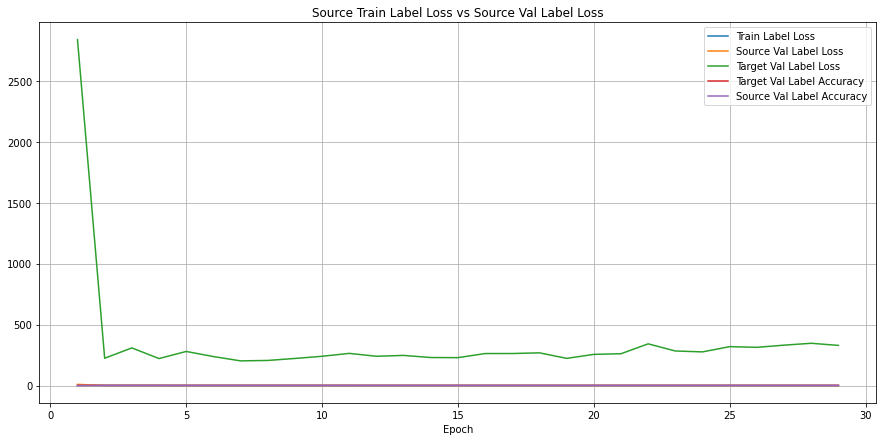

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

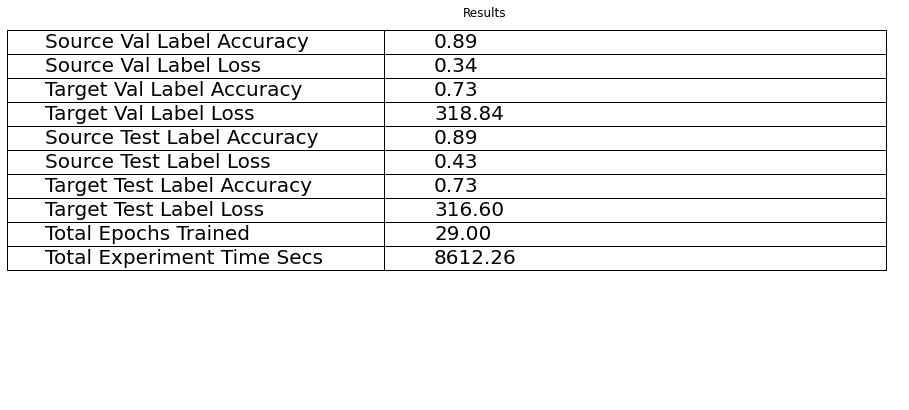

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

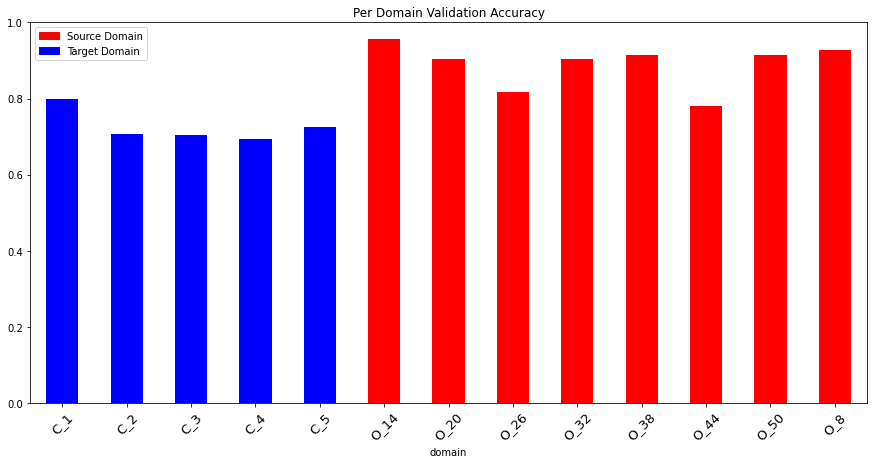

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.88955078125 Target Test Label Accuracy: 0.7265448645598194
Source Val Label Accuracy: 0.8900065104166667 Target Val Label Accuracy: 0.7271428571428571


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores", "parameters": {"experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores", "device": "cuda", "lr": 0.0001, "x_shape": [2, 200], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_